In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import matplotlib.colors as colors
import cmocean.cm as cmo
from glob import glob
from xorca.lib import load_xorca_dataset
import xgcm
import gsw
import cftime

In [1]:
86400 * 2

172800

In [2]:
Tfile = xr.open_mfdataset("/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-REF08-S/5d/" 
                      + "1996/CREG12.L75-REF08_y1996m01d05.5d_gridT.nc")
Ufile = xr.open_mfdataset("/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-REF08-S/5d/" 
                      + "1996/CREG12.L75-REF08_y1996m01d05.5d_gridU.nc")
Vfile = xr.open_mfdataset("/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-REF08-S/5d/" 
                      + "1996/CREG12.L75-REF08_y1996m01d05.5d_gridV.nc")

In [3]:
grid_files = ["/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mask.nc", 
              "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_hgr.nc",
              "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_zgr.nc"]
grid = xr.open_mfdataset(grid_files, parallel=True)

In [38]:
dz = grid.e3t_1d.squeeze().values

In [51]:
T = Tfile.votemper.where(Tfile.votemper!=0).isel(y=slice(800, None)).values[0, :, 1::, 1::]
S = Tfile.vosaline.where(Tfile.vosaline!=0).isel(y=slice(800, None)).values[0, :, 1::, 1::]
U = Ufile.vozocrtx.where(Ufile.vozocrtx!=0).isel(y=slice(800, None)).values
V = Vfile.vomecrty.where(Vfile.vomecrty!=0).isel(y=slice(800, None)).values

In [52]:
Ut = 0.5 * (U[0, :, 1::, 1::] + U[0, :, 1::, 0:-1])
Vt = 0.5 * (V[0, :, 1::, 1::] + V[0, :, 0:-1, 1::])

In [53]:
dudz = (Ut[0:-1,...] - Ut[1::,...]) / dz[0:-1, None, None]
dvdz = (Vt[0:-1,...] - Vt[1::,...]) / dz[0:-1, None, None]

In [54]:
shear = (dudz**2) + (dvdz**2)
shear[shear <= 0.] = 1e-20

In [92]:
g = 9.81

In [56]:
dTdz = (T[0:-1,...] - T[1::,...]) / dz[0:-1, None, None]
dSdz = (S[0:-1,...] - S[1::,...]) / dz[0:-1, None, None]

In [57]:
zt = 0.5 * (T[0:-1,...] + T[1::,...])         
zs = 0.5 * (S[0:-1,...] + S[1::,...]) - 35.0
zh = grid.gdepw_0[0, 1::, 801::, 1::]

In [58]:
albet = ((((-0.255019e-07 * zt + 0.298357e-05) * zt - 0.203814e-03) * zt + 0.170907e-01) 
         * zt + 0.665157e-01 + (-0.678662e-05 * zs - 0.846960e-04 * zt + 0.378110e-02 ) 
         * zs + ((-0.302285e-13 * zh - 0.251520e-11 * zs + 0.512857e-12 * zt * zt) * zh - 0.164759e-06 
                 * zs + (0.791325e-08 * zt - 0.933746e-06) * zt + 0.380374e-04 ) * zh)

beta  = (((-0.415613e-09 * zt + 0.555579e-07) * zt - 0.301985e-05) * zt + 0.785567e-03 
          + (0.515032e-08 * zs + 0.788212e-08 * zt - 0.356603e-06) * zs    
          + ((0.121551e-17 * zh - 0.602281e-15 * zs - 0.175379e-14 * zt + 0.176621e-12) * zh 
             + 0.408195e-10 * zs + (-0.213127e-11 * zt + 0.192867e-09) * zt - 0.121555e-07) * zh)

In [98]:
N2 = g * beta * ((albet * dTdz) - dSdz)
#N2 = 0.5 * (N2[0:-1,...] + N2[1::,...])

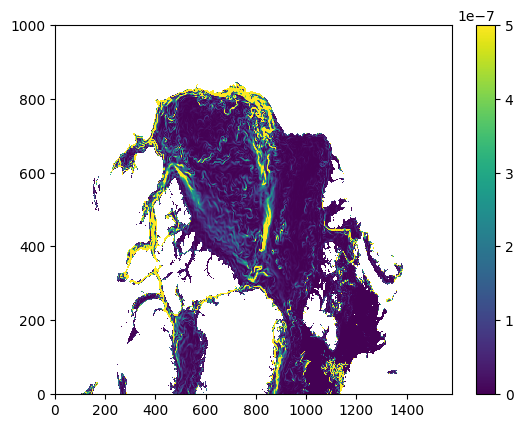

In [108]:
plt.pcolormesh(shear[25, ...], vmin=0, vmax=5e-7)
plt.colorbar()

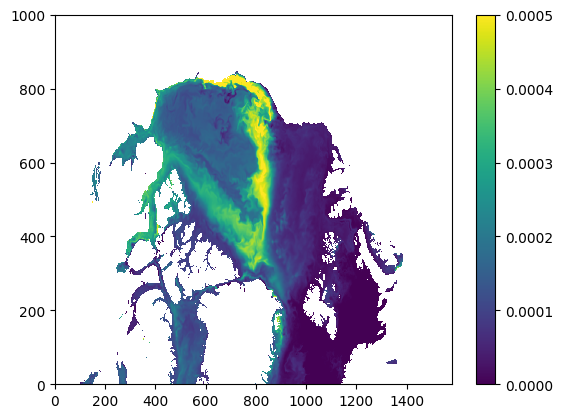

In [105]:
plt.pcolormesh(N2[25, ...], vmin=0, vmax=5e-4)
plt.colorbar()

In [113]:
N2CDF = xr.open_mfdataset("/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-Nsquared/1996/CREG12.L75-REF08_y1996m01d05*")

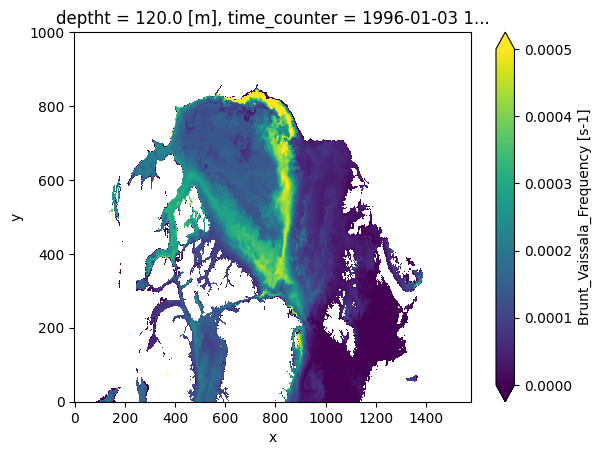

In [115]:
N2CDF.vobn2.isel(y=slice(800, None), deptht=25).plot(vmin=0, vmax=5e-4)

In [116]:
Ri = N2 / (shear)

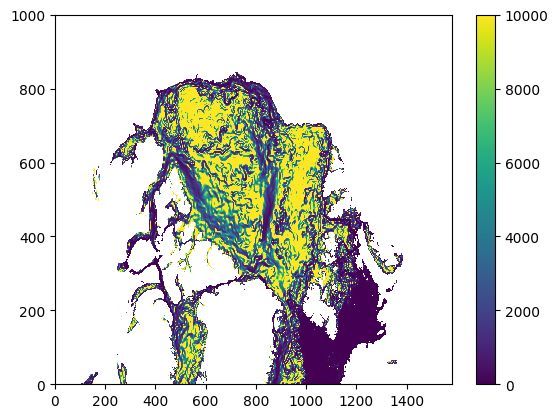

In [117]:
plt.pcolormesh(Ri[25, ...], vmin=0, vmax=10000)
plt.colorbar()

In [110]:
RiCDF = xr.open_mfdataset("/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-RI/1996/CREG12.L75-REF08_y1996m01d05*")

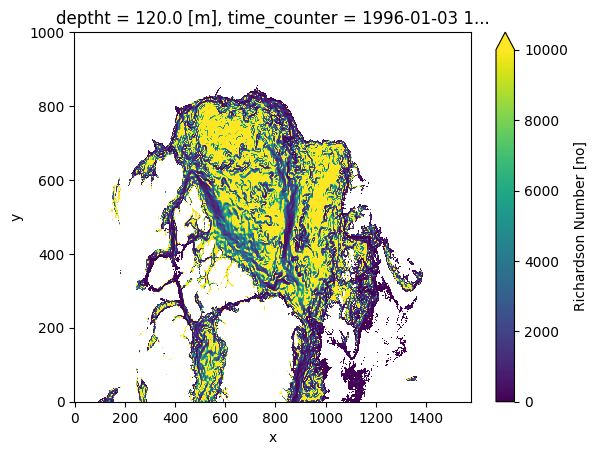

In [111]:
RiCDF.voric.isel(y=slice(800, None), deptht=25).plot(vmin=0, vmax=10000)

In [112]:
RiCDF.deptht[25]

<xarray.DataArray 'deptht' ()>
array(120., dtype=float32)
Coordinates:
    deptht   float32 120.0
Attributes:
    long_name:  Vertical T levels
    units:      m
    axis:       Z
    positive:   down
    bounds:     deptht_bounds